In [11]:
pip install pandas numpy matplotlib seaborn scikit-learn joblib

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score

# Load the dataset
df = pd.read_csv('/content/IRIS.csv')

# Data Exploration
print("Dataset Information:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())
print("\nClass Distribution:")
print(df['species'].value_counts())

# Data Visualization
plt.figure(figsize=(15, 10))

# Pairplot to visualize relationships between features
sns.pairplot(df, hue='species')
plt.suptitle('Pairplot of Iris Features by Species', y=1.02)
plt.savefig('pairplot.png')
plt.close()

# Boxplots for each feature by species
plt.figure(figsize=(15, 10))
for i, feature in enumerate(df.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='species', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Species')
plt.tight_layout()
plt.savefig('boxplots.png')
plt.close()

# Correlation matrix
plt.figure(figsize=(8, 6))
corr_matrix = df.iloc[:, :-1].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.close()

# Data Preprocessing
# Encode the species labels
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

# Split into features and target
X = df.iloc[:, :-1]
y = df['species']

# Feature Selection
# Using ANOVA F-value to select the most important features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Get the scores and p-values
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_,
    'P-value': selector.pvalues_
}).sort_values('Score', ascending=False)

print("\nFeature Importance Scores:")
print(feature_scores)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Development and Evaluation
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    cm = confusion_matrix(y_test, y_pred)

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores)
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-validation: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

# Determine the best model
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} with accuracy {results[best_model_name]['accuracy']:.4f}")

# Feature Importance for Random Forest (if it's the best model)
if isinstance(best_model, RandomForestClassifier):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nRandom Forest Feature Importances:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

# Save the best model
import joblib
joblib.dump(best_model, 'best_iris_model.pkl')

# Save the label encoder for future use
joblib.dump(label_encoder, 'label_encoder.pkl')

# Create a markdown report
with open('README.md', 'w') as f:
    f.write("# Iris Flower Classification Project\n\n")
    f.write("## Project Overview\n")
    f.write("This project develops a machine learning model to classify Iris flowers into three species based on their sepal and petal measurements.\n\n")

    f.write("## Dataset Information\n")
    f.write("The dataset contains measurements for 150 Iris flowers from three species:\n")
    f.write("- Iris-setosa (50 samples)\n")
    f.write("- Iris-versicolor (50 samples)\n")
    f.write("- Iris-virginica (50 samples)\n\n")

    f.write("## Feature Analysis\n")
    f.write("The most significant features for classification are:\n")
    for _, row in feature_scores.iterrows():
        f.write(f"- {row['Feature']}: F-score = {row['Score']:.2f}, p-value = {row['P-value']:.4f}\n")
    f.write("\n")

    f.write("## Model Performance\n")
    f.write("| Model | Accuracy | Cross-validation (mean ± std) |\n")
    f.write("|-------|----------|-------------------------------|\n")
    for name, result in results.items():
        f.write(f"| {name} | {result['accuracy']:.4f} | {result['cv_mean']:.4f} ± {result['cv_std']:.4f} |\n")
    f.write("\n")

    f.write(f"## Best Model: {best_model_name}\n")
    f.write(f"Accuracy: {results[best_model_name]['accuracy']:.4f}\n\n")

    f.write("## How to Use\n")
    f.write("1. Install required packages: `pip install pandas numpy matplotlib seaborn scikit-learn joblib`\n")
    f.write("2. Run the script: `python iris_classification.py`\n")
    f.write("3. To make predictions with the saved model:\n")
    f.write("```python\n")
    f.write("import joblib\n")
    f.write("model = joblib.load('best_iris_model.pkl')\n")
    f.write("encoder = joblib.load('label_encoder.pkl')\n")
    f.write("new_data = [[5.1, 3.5, 1.4, 0.2]]  # Example data\n")
    f.write("prediction = model.predict(new_data)\n")
    f.write("species = encoder.inverse_transform(prediction)\n")
    f.write("print(species[0])\n")
    f.write("```\n")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

First 5 rows:
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Summary Statistics:
       sepal_length  sepal_width  petal_length  petal_width
count  

<Figure size 1500x1000 with 0 Axes>


FEATURE DISTRIBUTION BY SPECIES


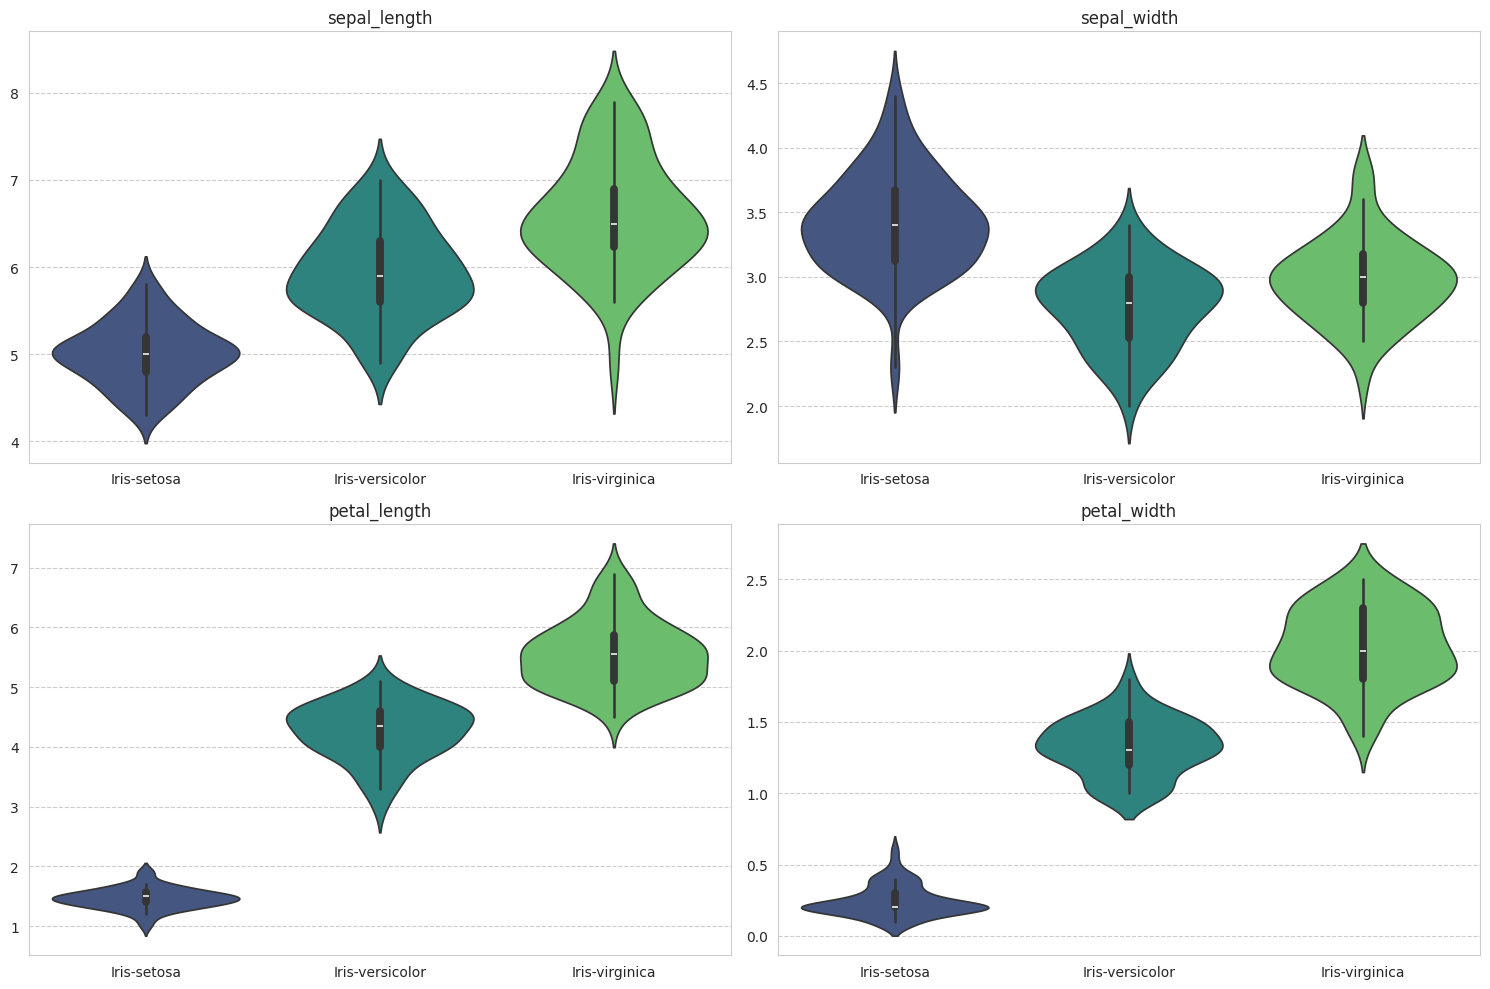


FEATURE IMPORTANCE ANALYSIS


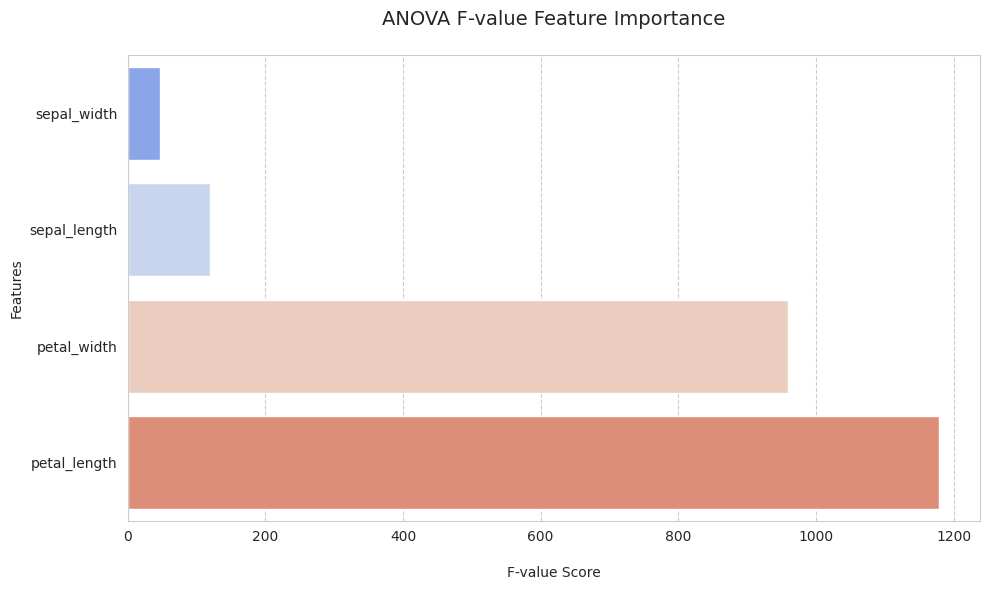


MODEL CONFUSION MATRICES


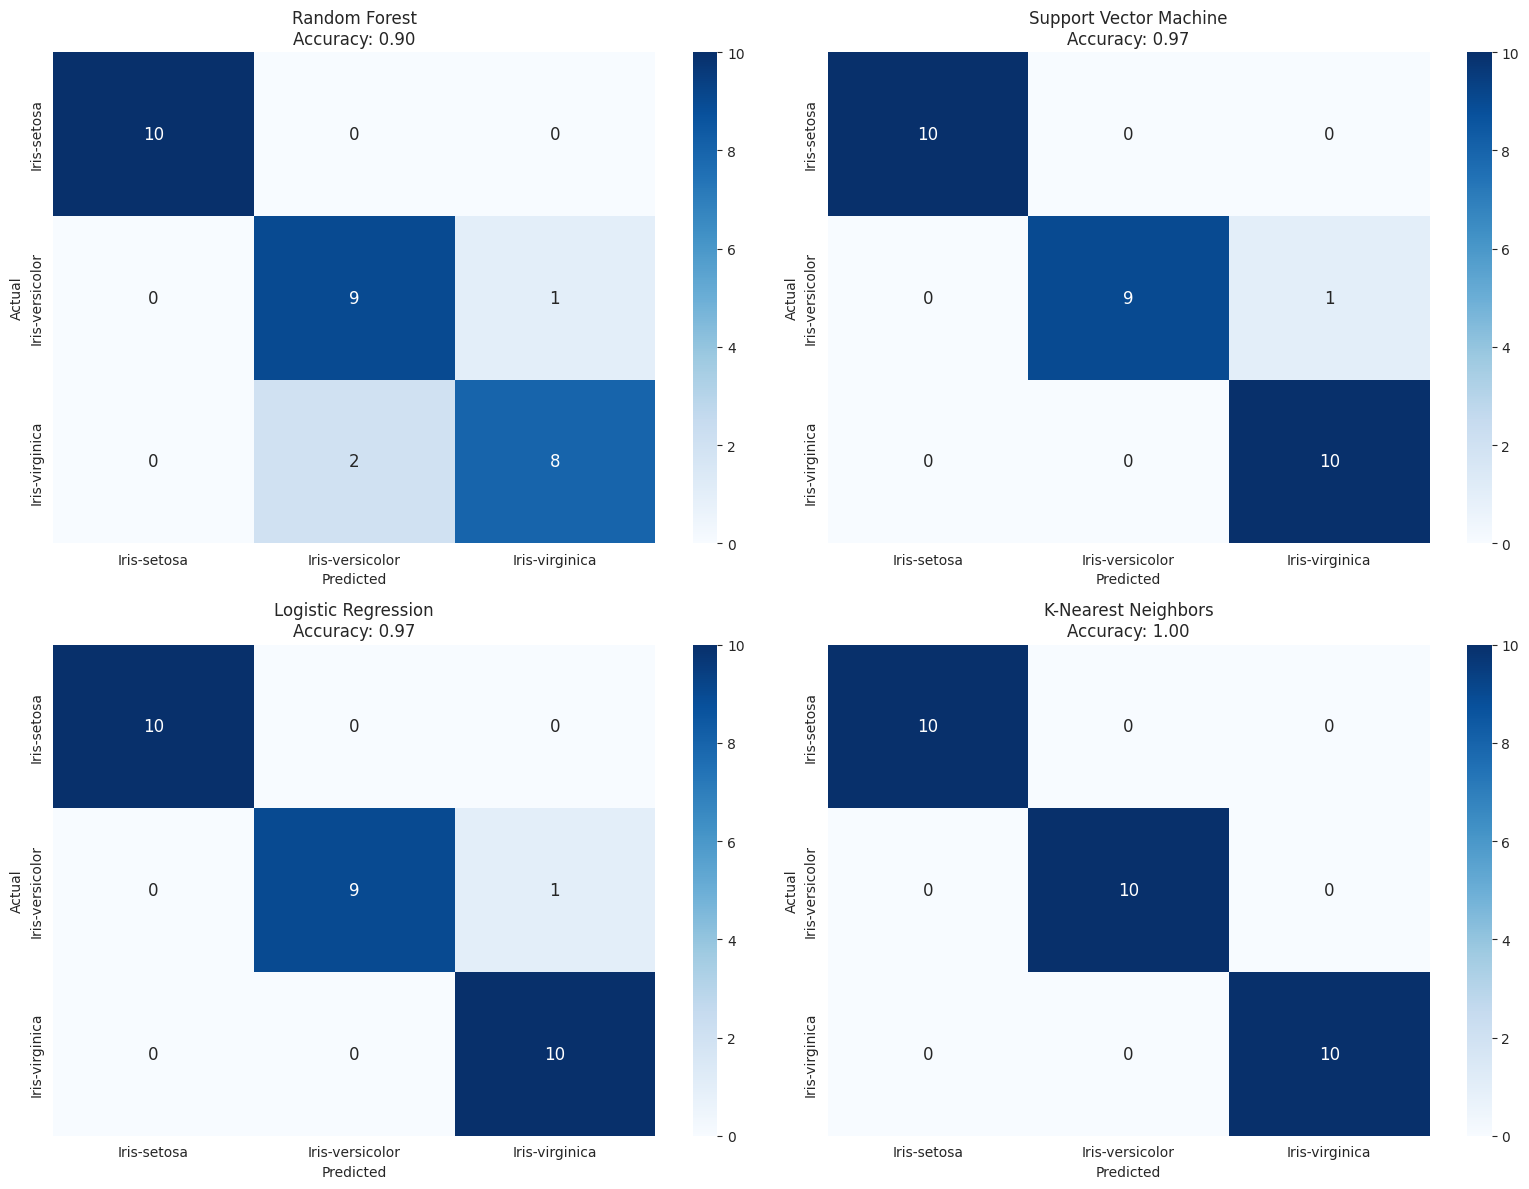


MODEL PERFORMANCE COMPARISON


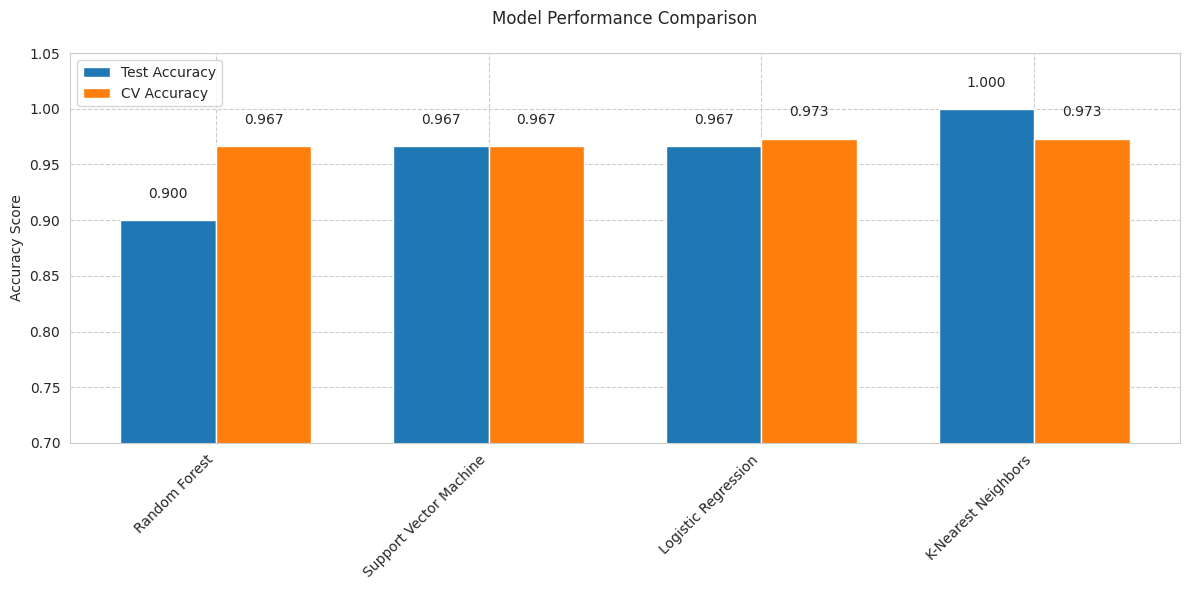


PARALLEL COORDINATES PLOT


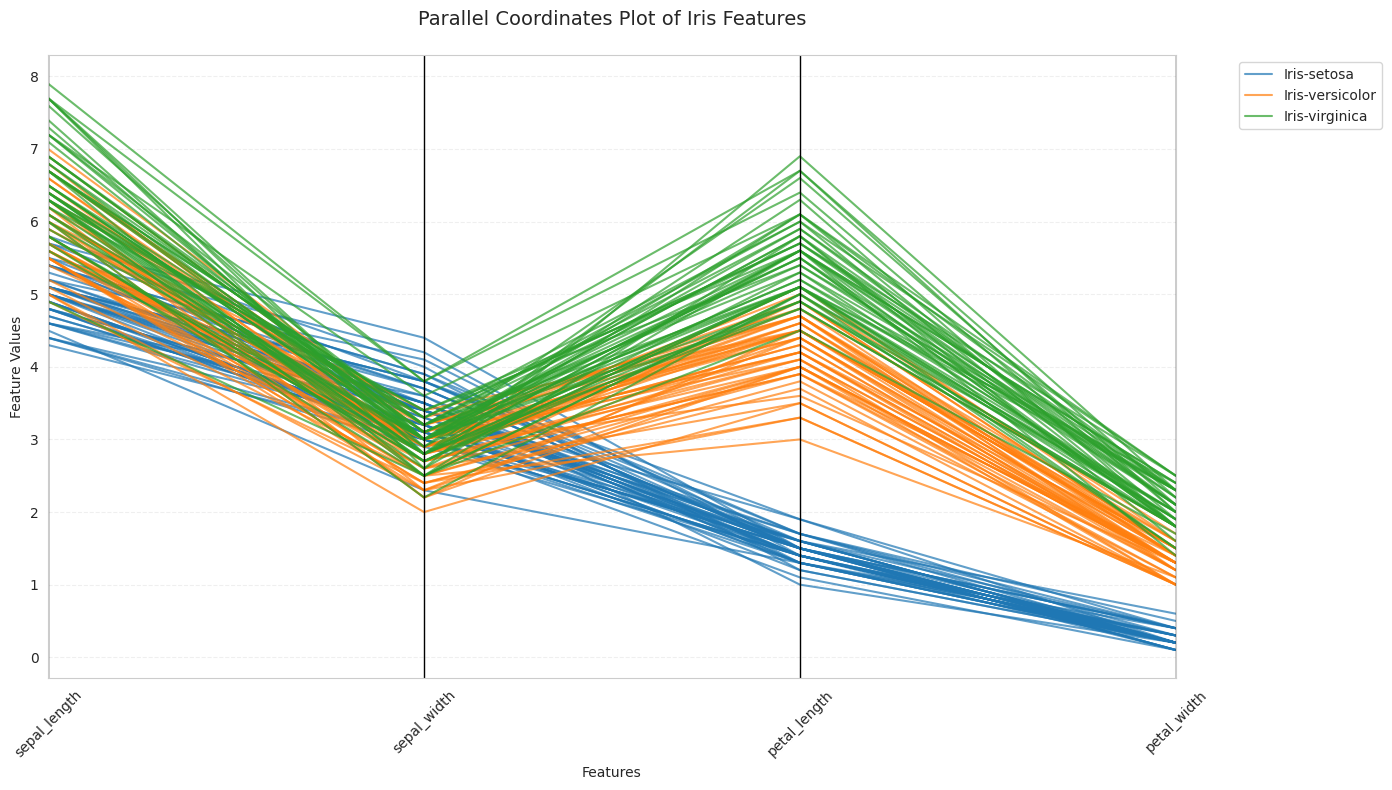

In [10]:
# Complete Visualization Code with Display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from IPython.display import display, HTML

# Set up styling
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.4})
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
sns.set_palette("viridis")

# Create a function to display plots with titles
def show_plot(fig, title):
    fig.suptitle(title, y=1.05, fontsize=14)
    plt.tight_layout()
    plt.show()
    plt.close()

# 1. Feature Distribution by Species
print("\n" + "="*60)
print("FEATURE DISTRIBUTION BY SPECIES")
print("="*60)

plt.figure(figsize=(15, 10))
species_names = label_encoder.inverse_transform(y)
plot_df = pd.concat([X, pd.Series(species_names, name='species')], axis=1)

for i, feature in enumerate(X.columns):
    plt.subplot(2, 2, i+1)
    sns.violinplot(x='species', y=feature, hue='species', data=plot_df,
                   palette='viridis', legend=False)
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.savefig('feature_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Feature Importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', hue='Feature',
            data=feature_scores.sort_values('Score'),
            palette='coolwarm', legend=False, dodge=False)
plt.title('ANOVA F-value Feature Importance\n', fontsize=14)
plt.xlabel('\nF-value Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('anova_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion Matrices
print("\n" + "="*60)
print("MODEL CONFUSION MATRICES")
print("="*60)

plt.figure(figsize=(16, 12))
for i, (name, result) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    sns.heatmap(result['confusion_matrix'],
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                annot_kws={'size': 12})
    plt.title(f'{name}\nAccuracy: {result["accuracy"]:.2f}', fontsize=12)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Model Comparison
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

plt.figure(figsize=(12, 6))
model_names = list(results.keys())
accuracies = [result['accuracy'] for result in results.values()]
cv_scores = [result['cv_mean'] for result in results.values()]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Test Accuracy', color='#1f77b4')
plt.bar(x + width/2, cv_scores, width, label='CV Accuracy', color='#ff7f0e')

plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison\n')
plt.xticks(x, model_names, rotation=45, ha='right')
plt.legend()
plt.ylim(0.7, 1.05)

for i, (acc, cv) in enumerate(zip(accuracies, cv_scores)):
    plt.text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center')
    plt.text(i + width/2, cv + 0.02, f'{cv:.3f}', ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Parallel Coordinates
print("\n" + "="*60)
print("PARALLEL COORDINATES PLOT")
print("="*60)

plt.figure(figsize=(14, 8))
parallel_df = pd.concat([X, pd.Series(species_names, name='species')], axis=1)
parallel_coordinates(parallel_df, 'species',
                    color=['#1f77b4', '#ff7f0e', '#2ca02c'],
                    alpha=0.7)
plt.title('Parallel Coordinates Plot of Iris Features\n', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Feature Values')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('parallel_coordinates.png', dpi=300, bbox_inches='tight')
plt.show()

